In [4]:
import cv2
import matplotlib.pyplot as plt
import math

##### Road test image

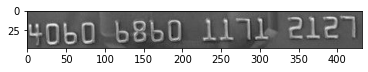

In [5]:
img_path = 'img/crop_number_test.png'
src = cv2.imread(img_path, 0)
plt.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGBA))
plt.show()

##### Calculate std on the x axis

In [6]:
def calc_std_xaxis(src, height, width):
    p_mean = []
    for x in range(width):
        p_sum = 0
        for y in range(height):
            p_sum += src[y][x]
        p_mean.append(p_sum / height)   
    # variance
    p_std = []
    for x in range(width):
        p_var = 0
        for y in range(height):
            p_var += (src[y][x] - p_mean[x])**2
        p_var = p_var / height
        # calcualte std
        p_std.append(math.sqrt(p_var))
    return p_std

In [7]:
# calculate std
h, w = src.shape
std_y = calc_std_xaxis(src, h, w)
thre_k = sum(std_y) // w - 3
print('threshold : ' + str(thre_k))

# candidate pixels
start_p = []
end_p = []

for x in range(1, w):
    if std_y[x-1] < thre_k and std_y[x] > thre_k: # up, start point
        start_p.append(x-1)
    if std_y[x-1] > thre_k and std_y[x] < thre_k: # down, end point
        end_p.append(x)

# 두 점 사이의 거리 width = end[i] - start[i]
# ROI 왼쪽 이미지가 조금 잘린 경우 end point가 더 많이 잡히면서 마이너스가 나오며 역방향이 됨
# end_point 리스트가 더 많은 경우 맨 앞의 값을 하나 없애고 당긴다
# 일반적으로는 end point list의 크기가 더 작다
width_y = []
min_list = len(end_p)
if len(start_p) < len(end_p):
    end_p.pop(0)
    min_list = len(start_p)

for x in range(min_list):
    distance = end_p[x] - start_p[x]
    width_y.append(distance)

threshold : 21.0


width : [13, 3, 17, 18, 17, 17, 17, 18, 17, 16, 16, 3, 7, 10, 16, 18, 16, 18, 16]
start : [2, 15, 24, 46, 70, 114, 136, 158, 181, 227, 249, 269, 272, 279, 294, 337, 361, 382, 407]
end : [15, 18, 41, 64, 87, 131, 153, 176, 198, 243, 265, 272, 279, 289, 310, 355, 377, 400, 423]


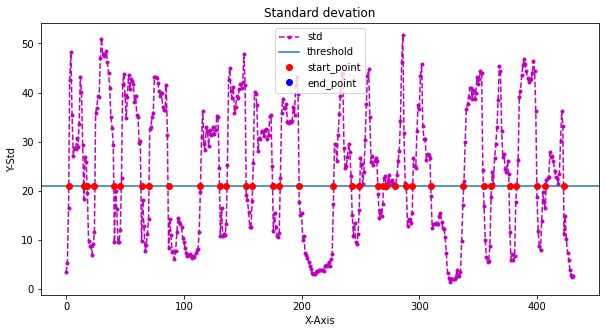

In [8]:
# draw point 그래프를 위한 빈 리스트
draw_start = [None for _ in range(w)]
draw_end = [None for _ in range(w)]

for i in start_p:
    draw_start[int(i)] = thre_k

for i in end_p:
    draw_start[int(i)] = thre_k

print('width : {}'.format(width_y))
print('start : {}'.format(start_p))
print('end : {}'.format(end_p))

plt.figure(figsize=(10, 5))

plt.plot(std_y, 'm--.', label='std')
plt.axhline(y=thre_k, label='threshold')
plt.plot(draw_start, 'ro', label='start_point')
plt.plot(draw_end, 'bo', label='end_point')

plt.title('Standard devation')
plt.legend()
plt.xlabel('X-Axis')
plt.ylabel('Y-Std')

plt.show()

##### Calculate width and crop the image

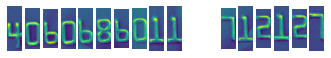

In [9]:
fig = plt.figure()
rows = 1
cols = len(width_y)

# 거리 계산시 절대값 
thre_w = sum(width_y) // len(width_y) # 평균
crop_imgs = []

for i in range(min_list):
    if width_y[i] >= thre_w: # width 값 설정
        crop = src[:, start_p[i]:end_p[i]]
        crop_imgs.append(crop)
        # draw
        ax = fig.add_subplot(rows, cols, i+1)
        ax.axis('off')
        ax.imshow(crop)
    else:
        if i == 0:
            continue
        pos = 0
        cnt = i # 작은 인덱스를 저장
        while(pos < thre_w):
            if width_y[cnt] > thre_w:
                break
            pos += width_y[cnt]
            cnt -= 1
        if pos >= thre_w:
            crop = src[:, start_p[cnt+1]:end_p[i]]
            crop_imgs.append(crop)
            width_y[i] += thre_w # threshold를 높혀서 다음에 다시 잘리는걸 방지
            # draw
            ax = fig.add_subplot(rows, cols, i+1)
            ax.axis('off')
            ax.imshow(crop)
plt.show()

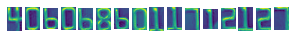

In [10]:
def crop_from_y_axis(src):
    h, w = src.shape
    mean_x = []
    for y in range(h):
        sum_x = 0
        for x in range(w):
            sum_x += src[y][x]
        mean_x.append(sum_x / w)

    std_x = []
    for y in range(h):
        var_x = 0
        for x in range(w):
            var_x += (src[y][x] - mean_x[y])**2
        std_x.append((math.sqrt(var_x / h)))
    
    k = sum(std_x) / h
    op = h
    ed = 0

    for i in range(len(std_x)):
        if std_x[i] > k and op > i:
            op = i
        if std_x[i] > k and ed < i:
            ed = i
    return op, ed

# draw
fig = plt.figure()
for idx in range(len(crop_imgs)):
    start, end = crop_from_y_axis(crop_imgs[idx])
    crop = crop_imgs[idx][start:end, :]
    crop_imgs[idx] = crop
    # draw
    ax = fig.add_subplot(rows, cols, idx + 1)
    ax.axis('off')
    ax.imshow(crop)    
plt.show()
